In [1]:
from datetime import datetime, timedelta
from strategy.stratfact import StratFact
from backtester.backtester import Backtester
from processor.processor import Processor as p
from tqdm import tqdm
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start = datetime(2017,1,1)
end = datetime(2018,1,1)
seats = 5

## Rolling Percent Backtest Testing

In [3]:
rp = StratFact.create_strat(start,end,"rolling_percent",modeling_params={"days":100,"currency":"prices"},
                        trading_params={"requirement":5,"value":
                                       False})
fp = StratFact.create_strat(start,end,"financial_predict",
                    modeling_params={"score_requirement":70,"categories":2,"model_training_year":4},
                    trading_params= {"requirement":10,"value":True})
pr = StratFact.create_strat(start,end,"progress_report",{},{"value":True,"requirement":5})
spec = StratFact.create_strat(start,end,"speculation",{
                    "number_of_training_weeks":14
                    ,"categories":2
                    ,"model_training_year":1
                    ,"score_requirement":70
                        },{
                    "score_requirement":70
                    ,"requirement":5
                    ,"value":True})
comp = StratFact.create_strat(start,end,"competition",modeling_params={
                    "categories":2
                    ,"model_training_year":1
                    ,"score_requirement":70
                        },
                        trading_params={
                    "score_requirement":70
                    ,"requirement":5
                    ,"value":True})
strats = {"rolling_percent":rp,"financial_predict":fp,"progress_report":pr,"speculation":spec,"competition":comp}

In [4]:
all_trades = []
for strat in tqdm(strats,desc="strategy_count"):
    strategy = strats[strat]
    strategy.subscribe()
    strategy.db.connect()
    sim = strategy.db.retrieve_sim(strategy.modeling_params)
    strategy.db.disconnect()
    sim = p.column_date_processing(sim)
    bt = Backtester(strategy)
    trades = bt.equity_timeseries_backtest(start,end,seats)
    t = pd.DataFrame(trades)
    t["strategy"] = strat
    all_trades.append(t)

strategy_count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:59<00:00, 47.85s/it]


In [5]:
at = pd.concat(all_trades)
at["delta"] = (at["sell_price"] - at["adjclose"]) / at["adjclose"]

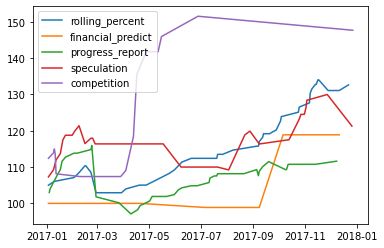

In [6]:
all_analysis = []
for strat in strats:
    strat_trades = at[at["strategy"]==strat]
    cash = []
    stuff = []
    total_cash = 100
    number_of_strats=1
    for seat in range(seats):
        initial = float(total_cash / number_of_strats / seats )
        seat_trades = strat_trades[strat_trades["seat"]==seat]
        for delta in seat_trades["delta"]:
            initial = initial * (1+delta)
            cash.append(initial)
    strat_trades["pv"] = cash
    stuff.append(strat_trades)
    analysis = pd.concat(stuff).pivot_table(index=["date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
    analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]
    analysis["strategy"] = strat
    all_analysis.append(analysis)
    plt.plot(analysis["date"],analysis["pv"])
plt.legend(strats.keys())
plt.show()

In [7]:
heh = pd.concat(all_analysis).sort_values("date").pivot_table(index="date",columns="strategy",values="pv")
heh.iloc[0] = heh.iloc[0].fillna(100)
heh.fillna(method="ffill")

strategy,competition,financial_predict,progress_report,rolling_percent,speculation
date,,,,,
2017-01-03,112.417992,100.000000,100.000000,105.000000,107.283392
2017-01-04,112.417992,100.000000,103.000000,105.000000,107.283392
2017-01-05,112.417992,100.000000,104.000000,105.000000,107.283392
2017-01-09,113.902269,100.000000,104.000000,105.000000,109.267639
2017-01-10,114.995299,100.000000,104.000000,106.050000,109.267639
...,...,...,...,...,...
2017-12-08,151.534579,118.877985,111.616328,131.078796,129.980213
2017-12-11,151.534579,118.877985,111.616328,131.078796,129.980213
2017-12-22,151.534579,118.877985,111.616328,132.630124,129.980213
